In [1]:
# Import Tensor Libs
import numpy as np
import awkward as ak

# Import ML Libs
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Import Plotting Libs
import matplotlib.pyplot as plt

In [2]:
# Check if GPU is available, if not use cpu
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU Available:  True


In [3]:
class ParticleDataset(Dataset):
    def __init__(self, data, labels, device):
        self.data = torch.tensor(data, dtype=torch.float32).to(device)
        self.labels = torch.tensor(labels, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        event = self.data[idx]
        label = self.labels[idx]
        return event, label

In [4]:
train_dataset = torch.load("../datasets/train_dataset_700k.pt", weights_only=False, map_location=device)
val_dataset = torch.load("../datasets/val_dataset_50k.pt", weights_only=False, map_location=device)
test_dataset = torch.load("../datasets/test_dataset_250k.pt", weights_only=False, map_location=device)

train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=True)

In [5]:
for inputs, labels in train_dataloader:
    print("Batch shape:", inputs.shape)
    print("Labels shape:", labels.shape)
    padding_particle_cutoff=inputs.shape[1]
    break

Batch shape: torch.Size([1024, 100, 3])
Labels shape: torch.Size([1024, 1])


In [6]:
# Define the Model
class MultiLayerPerceptron(nn.Module):
    '''
    A DL model with customizable layers and nodes. 
    '''
    def __init__(self, in_dim, hidden_dim, num_layers, out_dim):
        super(MultiLayerPerceptron, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_dim, hidden_dim))
        hidden_layers = [hidden_dim]*num_layers
        for i in range(num_layers):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, 1))

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        for layer in self.layers[:-1]:
            x = F.gelu(layer(x))
        x = F.sigmoid(self.layers[-1](x))
        return x

In [7]:
# Define a class that inherits from torch.nn.Module
class DeepSets(nn.Module):
    '''
    A DeepSets model that performs graph level classification on a dense graph. 
    '''
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(DeepSets, self).__init__()
        self.init = nn.Linear(in_dim, hidden_dim)
        self.Messages = nn.Linear(hidden_dim,hidden_dim)
        self.PostProcess = nn.Linear(hidden_dim,hidden_dim)
        self.Classification = nn.Linear(hidden_dim,out_dim)
    def forward(self, data):
        track_embedding = F.gelu(self.init(data))
        messages = F.gelu(self.Messages(track_embedding))
        aggregated_message = torch.sum(messages,dim=1)
        event_embedding = F.gelu(self.PostProcess(aggregated_message))
        output = F.sigmoid(self.Classification(event_embedding))
        return output

In [8]:
# Define a class that inherits from torch.nn.Module
class TransformerEncoder(nn.Module):
    '''
    An Attention model that performs set level classification on a set. 
    '''
    def __init__(self, in_dim, hidden_dim, num_encoders, out_dim):
        super(TransformerEncoder, self).__init__()
        self.init = nn.Linear(in_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=1, dim_feedforward=hidden_dim,dropout=0, batch_first=True)        # Define linear transformation 1
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)
        self.Classification = nn.Linear(hidden_dim,out_dim)
    def forward(self, data):
        embedding = F.gelu(self.init(data))
        embedding = F.gelu(self.transformer_encoder(embedding))
        embedding = torch.mean(embedding,dim=1)
        output = F.sigmoid(self.Classification(embedding))
        return output

In [9]:
# Define the training loop
def train(model, optimizer, loss_fn, train_dataloader, val_dataloader, lr_step, epochs=20):

    history = {'train_loss':[],'test_loss':[]}     # Define history dictionary

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=0.1)
    # Loop through epoches
    for e in range(epochs):
        for X_train, y_train in train_dataloader:
            # Train Model
            model.train()                        # Switch model to training mode
            optimizer.zero_grad()                # Reset the optimizers gradients
            y_pred = model(X_train)             # Get the model prediction
            loss = loss_fn(y_pred, y_train)     # Evaluate loss function
            loss.backward()                      # Backward propogation
            optimizer.step()                     # Gradient Descent
        for X_val, y_val in val_dataloader:
            # Validate Model
            model.eval()
            y_pred = model(X_val)    # Get model output on test data
            test_loss = loss_fn(y_pred,y_val)   # Evaluate loss on test preditions
        
        history['train_loss'].append(loss.detach().cpu().numpy())        # Append train loss to history (detach and convert to numpy array)
        history['test_loss'].append(test_loss.detach().cpu().numpy())    # Append test loss to history (detach and convert to numpy array)
        if (e+1)%1==0:
            print('Epoch:',e+1,'\tTrain Loss:',round(float(loss),4),'\tTest Loss:',round(float(test_loss),4))
        scheduler.step()
        if (e+1)%lr_step==0:
            print("\tReducing Learning Rate!")
    return history

MultiLayerPerceptron(
  (layers): ModuleList(
    (0): Linear(in_features=300, out_features=164, bias=True)
    (1-2): 2 x Linear(in_features=164, out_features=164, bias=True)
    (3): Linear(in_features=164, out_features=1, bias=True)
  )
)
Trainable Parameters:  103649 

Epoch: 1 	Train Loss: 0.662 	Test Loss: 0.6748
Epoch: 2 	Train Loss: 0.6595 	Test Loss: 0.6508
Epoch: 3 	Train Loss: 0.6217 	Test Loss: 0.6295
Epoch: 4 	Train Loss: 0.5887 	Test Loss: 0.6146
Epoch: 5 	Train Loss: 0.5733 	Test Loss: 0.586
Epoch: 6 	Train Loss: 0.569 	Test Loss: 0.5638
Epoch: 7 	Train Loss: 0.5384 	Test Loss: 0.5456
Epoch: 8 	Train Loss: 0.5328 	Test Loss: 0.5594
Epoch: 9 	Train Loss: 0.519 	Test Loss: 0.4975
Epoch: 10 	Train Loss: 0.5207 	Test Loss: 0.4915
Epoch: 11 	Train Loss: 0.4818 	Test Loss: 0.4851
Epoch: 12 	Train Loss: 0.4883 	Test Loss: 0.4726
Epoch: 13 	Train Loss: 0.4561 	Test Loss: 0.455
Epoch: 14 	Train Loss: 0.4656 	Test Loss: 0.4623
Epoch: 15 	Train Loss: 0.4373 	Test Loss: 0.4269
	Redu

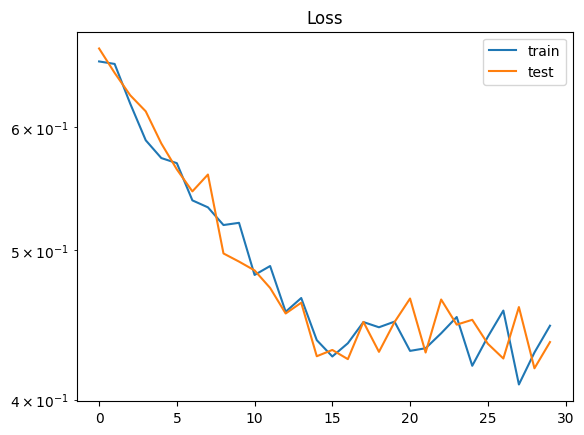

In [10]:
# Initialize model
MLP = MultiLayerPerceptron(in_dim=3*padding_particle_cutoff,hidden_dim=164, num_layers=2, out_dim=1)    # Declare model using NeuralNet Class
MLP.to(device)                                       # Put model on device (cpu or gpu)
print(MLP)                                           # Print layers in model

# Calculate and print trainable parameters
pytorch_total_params = sum(p.numel() for p in MLP.parameters() if p.requires_grad)
print("Trainable Parameters: ", pytorch_total_params,"\n")

# Declare optimizer and loss function
optimizer = optim.AdamW(MLP.parameters(), lr=1e-6)  # Adam = Adaptive Moment Estimation, lr = learning rate
loss_fn = nn.BCELoss()                                 # BCE = Binary Cross Entropy, used for binary classification

#Train Model
history = train(MLP, optimizer, loss_fn, train_dataloader, val_dataloader, lr_step=15, epochs=30)                                             # Train the model!

# Plot Training History
plt.plot(history['train_loss'],label='train')
plt.plot(history['test_loss'],label='test')
plt.title("Loss")
plt.legend()
plt.yscale('log')
plt.show()

torch.save(MLP, "MLP.pt")

DeepSets(
  (init): Linear(in_features=3, out_features=222, bias=True)
  (Messages): Linear(in_features=222, out_features=222, bias=True)
  (PostProcess): Linear(in_features=222, out_features=222, bias=True)
  (Classification): Linear(in_features=222, out_features=1, bias=True)
)
Trainable Parameters:  100123 

Epoch: 1 	Train Loss: 0.4058 	Test Loss: 0.4392
Epoch: 2 	Train Loss: 0.3487 	Test Loss: 0.3808
Epoch: 3 	Train Loss: 0.3832 	Test Loss: 0.3459
Epoch: 4 	Train Loss: 0.3414 	Test Loss: 0.3687
Epoch: 5 	Train Loss: 0.3509 	Test Loss: 0.3803
Epoch: 6 	Train Loss: 0.3482 	Test Loss: 0.3213
Epoch: 7 	Train Loss: 0.3395 	Test Loss: 0.3385
Epoch: 8 	Train Loss: 0.3277 	Test Loss: 0.3385
Epoch: 9 	Train Loss: 0.3304 	Test Loss: 0.328
Epoch: 10 	Train Loss: 0.3066 	Test Loss: 0.3257
Epoch: 11 	Train Loss: 0.3162 	Test Loss: 0.3232
Epoch: 12 	Train Loss: 0.3342 	Test Loss: 0.3191
Epoch: 13 	Train Loss: 0.3254 	Test Loss: 0.317
Epoch: 14 	Train Loss: 0.3764 	Test Loss: 0.3477
Epoch: 15 	T

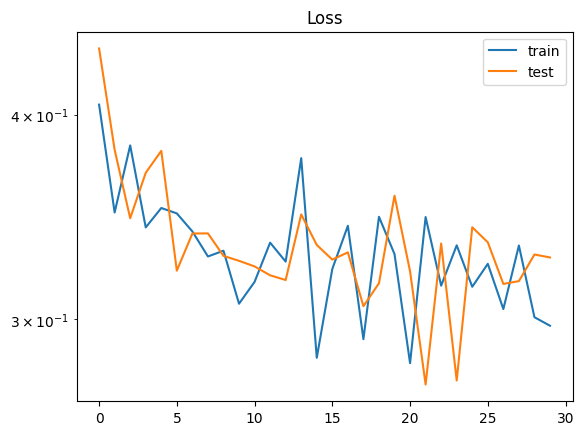

In [11]:
# Initialize model
GNN = DeepSets(in_dim=3,hidden_dim=222,out_dim=1)    # Declare model using NeuralNet Class
GNN.to(device)                                       # Put model on device (cpu or gpu)
print(GNN)                                           # Print layers in model

# Calculate and print trainable parameters
pytorch_total_params = sum(p.numel() for p in GNN.parameters() if p.requires_grad)
print("Trainable Parameters: ", pytorch_total_params,"\n")

# Declare optimizer and loss function
optimizer = optim.AdamW(GNN.parameters(), lr=1e-6)  # Adam = Adaptive Moment Estimation, lr = learning rate
loss_fn = nn.BCELoss()                                 # BCE = Binary Cross Entropy, used for binary classification

#Train Model
history = train(GNN, optimizer, loss_fn, train_dataloader, val_dataloader, lr_step=15, epochs=30)                                             # Train the model!

# Plot Training History
plt.plot(history['train_loss'],label='train')
plt.plot(history['test_loss'],label='test')
plt.title("Loss")
plt.legend()
plt.yscale('log')
plt.show()

torch.save(GNN, "GNN.pt")

TransformerEncoder(
  (init): Linear(in_features=3, out_features=90, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=90, out_features=90, bias=True)
        )
        (linear1): Linear(in_features=90, out_features=90, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=90, out_features=90, bias=True)
        (norm1): LayerNorm((90,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((90,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
      )
    )
  )
  (Classification): Linear(in_features=90, out_features=1, bias=True)
)
Trainable Parameters:  99451 



/home/lvaughan/ML_Tutorial_2025/software/ML_Tutorial_2025/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch: 1 	Train Loss: 0.4213 	Test Loss: 0.4188
Epoch: 2 	Train Loss: 0.3615 	Test Loss: 0.3498
Epoch: 3 	Train Loss: 0.3654 	Test Loss: 0.3536
Epoch: 4 	Train Loss: 0.2972 	Test Loss: 0.3142
Epoch: 5 	Train Loss: 0.3581 	Test Loss: 0.326
Epoch: 6 	Train Loss: 0.2824 	Test Loss: 0.3446
Epoch: 7 	Train Loss: 0.3027 	Test Loss: 0.3213
Epoch: 8 	Train Loss: 0.2925 	Test Loss: 0.3237
Epoch: 9 	Train Loss: 0.301 	Test Loss: 0.3473
Epoch: 10 	Train Loss: 0.3369 	Test Loss: 0.3558
Epoch: 11 	Train Loss: 0.3402 	Test Loss: 0.3277
Epoch: 12 	Train Loss: 0.3009 	Test Loss: 0.3507
Epoch: 13 	Train Loss: 0.3521 	Test Loss: 0.3186
Epoch: 14 	Train Loss: 0.3063 	Test Loss: 0.3128
Epoch: 15 	Train Loss: 0.33 	Test Loss: 0.2874
	Reducing Learning Rate!
Epoch: 16 	Train Loss: 0.343 	Test Loss: 0.3077
Epoch: 17 	Train Loss: 0.3102 	Test Loss: 0.3487
Epoch: 18 	Train Loss: 0.3109 	Test Loss: 0.311
Epoch: 19 	Train Loss: 0.2994 	Test Loss: 0.3168
Epoch: 20 	Train Loss: 0.3235 	Test Loss: 0.3552
Epoch: 21 

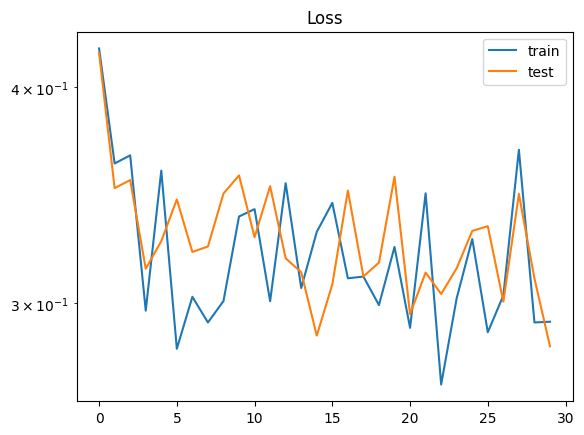

In [12]:
# Initialize model
Transformer = TransformerEncoder(in_dim=3,hidden_dim=90,num_encoders=2,out_dim=1)    # Declare model using NeuralNet Class
Transformer.to(device)                                       # Put model on device (cpu or gpu)
print(Transformer)                                           # Print layers in model

# Calculate and print trainable parameters
pytorch_total_params = sum(p.numel() for p in Transformer.parameters() if p.requires_grad)
print("Trainable Parameters: ", pytorch_total_params,"\n")

# Declare optimizer and loss function
optimizer = optim.AdamW(Transformer.parameters(), lr=1e-5)  # Adam = Adaptive Moment Estimation, lr = learning rate
loss_fn = nn.BCELoss()                                 # BCE = Binary Cross Entropy, used for binary classification

#Train Model
history = train(Transformer, optimizer, loss_fn, train_dataloader, val_dataloader, lr_step=15, epochs=30)                                             # Train the model!

# Plot Training History
plt.plot(history['train_loss'],label='train')
plt.plot(history['test_loss'],label='test')
plt.title("Loss")
plt.legend()
plt.yscale('log')
plt.show()

torch.save(Transformer, "Transformer.pt")

In [13]:
MLP = torch.load("MLP.pt", weights_only=False, map_location=device)
GNN = torch.load("GNN.pt", weights_only=False, map_location=device)
Transformer = torch.load("Transformer.pt", weights_only=False, map_location=device)

In [14]:
# Define traditional ROC curve
def roc(y_pred,y_true):    
    sig_eff = []
    bkg_eff = []
    
    sig = y_true==1
    bkg = y_true==0
    
    thresholds = np.linspace(0,1,100)
    
    # Iterate over thresholds and calculate sig and bkg efficiency
    for threshold in thresholds:
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))   # Sum over sig predictions > threshold and divide by total number of true sig instances 
        bkg_eff.append(((y_pred[bkg] < threshold).sum()  / y_true[bkg].shape[0]))  # Sum over bkg predictions < threshold and divide by total number of true bkg instances 
        
    return np.array(sig_eff), np.array(bkg_eff), thresholds

# Define ATLAS Style ROC curve
def ATLAS_roc(y_pred,y_true):
    sig_eff = []
    bkg_eff = []
    
    sig = y_true==1
    bkg = y_true==0
    
    thresholds = np.linspace(0,1,1000)
    
    for threshold in thresholds:
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))
        bkg_eff.append(1-((y_pred[bkg] < threshold).sum()  / y_true[bkg].shape[0]))
        
    bkg_rej = [1/x for x in bkg_eff]  # ATLAS inverts bkg eff and uses bkg rejection instead
    return np.array(sig_eff), np.array(bkg_rej), thresholds

In [15]:
def eval_model(model, loss_fn, test_dataloader):
    # Get Models predictions
    prediction = []
    truth = []
    test_loss = []
    for X_test, y_test in test_dataloader:
        model.eval()
        y_pred = model(X_test)    # Get model output on test data
        loss = loss_fn(y_pred,y_test)
        test_loss.append(loss.detach().cpu().numpy())   # Evaluate loss on test preditions
        prediction.append(y_pred.detach().cpu().numpy())
        truth.append(y_test.detach().cpu().numpy())

    prediction = np.array(ak.ravel(prediction))
    truth = np.array(ak.ravel(truth))
    
    # Find indices of sig and bkg labels
    sig = np.where(truth==1)
    bkg = np.where(truth==0)
    
    eff_sig, eff_bkg, thresh = roc(prediction,truth)
    
    WPs = [25,50,75]
    cuts = []
    for WP in WPs:
        mask = eff_sig>(WP/100)
        idx = len(eff_sig[mask])-1
        cut = thresh[idx]
        cuts.append(cut)

    # Plot Model Predictions
    plt.title(model.__class__.__name__+" Predictions")
    plt.hist(prediction[sig],histtype='step',color='r',label="sig",bins=40)
    plt.hist(prediction[bkg],histtype='step',color='b',label="bkg",bins=40)
    colors=['c','m','y']
    labels=[str(x)+"% WP" for x in WPs]
    for i, cut in enumerate(cuts):
        plt.axvline(cut,linestyle='--',color=colors[i%3],label=labels[i])
    plt.xlabel("Model Score")
    plt.ylabel("Events")
    #plt.yscale('log')
    plt.legend()
    plt.show()
    
    return prediction, truth

/tmp/ipykernel_1241574/2091679916.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  prediction = np.array(ak.ravel(prediction))
/tmp/ipykernel_1241574/2091679916.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  truth = np.array(ak.ravel(truth))


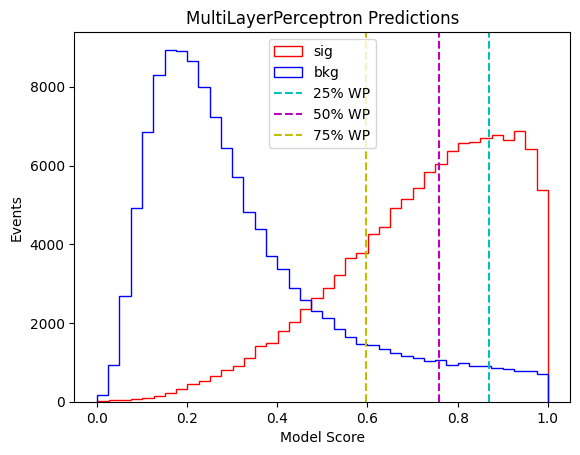

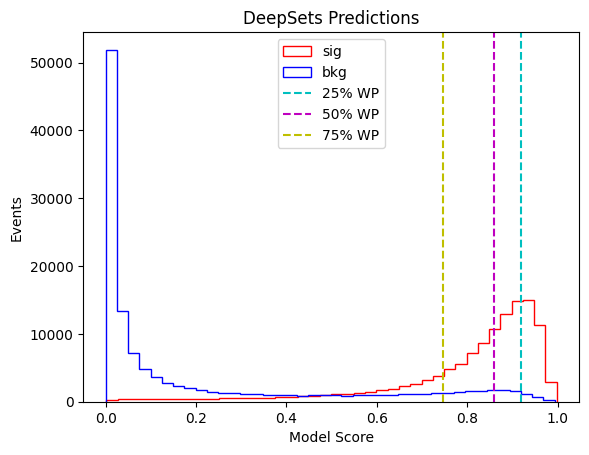

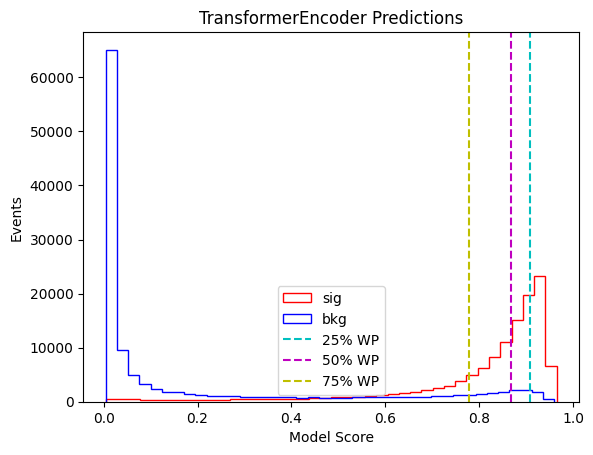

In [16]:
loss_fn = nn.BCELoss()
MLP_pred, MLP_true = eval_model(MLP, loss_fn, test_dataloader)
GNN_pred, GNN_true = eval_model(GNN, loss_fn, test_dataloader)
Trans_pred, Trans_true = eval_model(Transformer, loss_fn, test_dataloader)

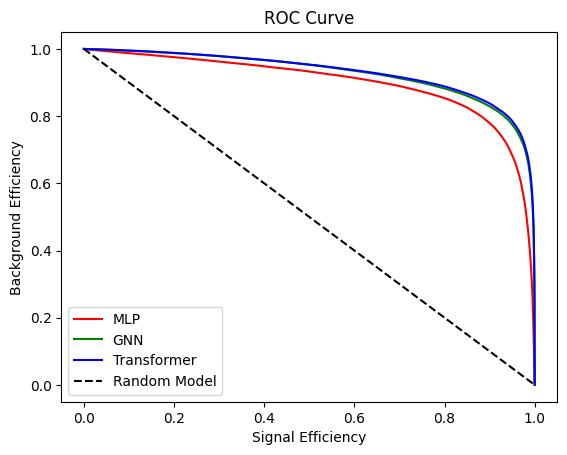

/tmp/ipykernel_1241574/437800572.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  bkg_rej = [1/x for x in bkg_eff]  # ATLAS inverts bkg eff and uses bkg rejection instead


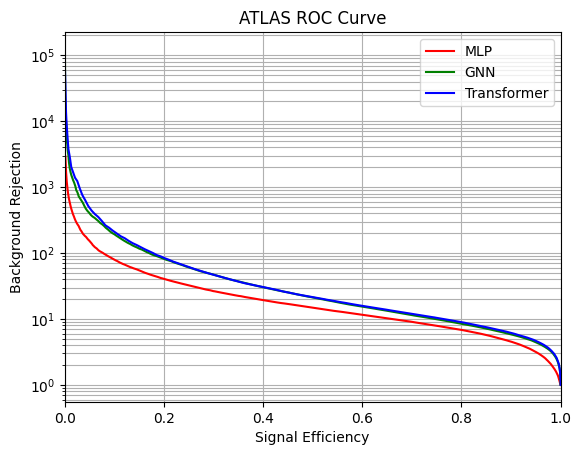

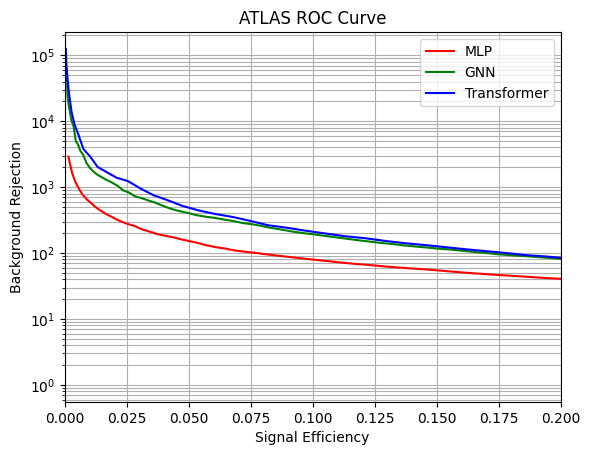

/tmp/ipykernel_1241574/2694610665.py:54: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0, 18])


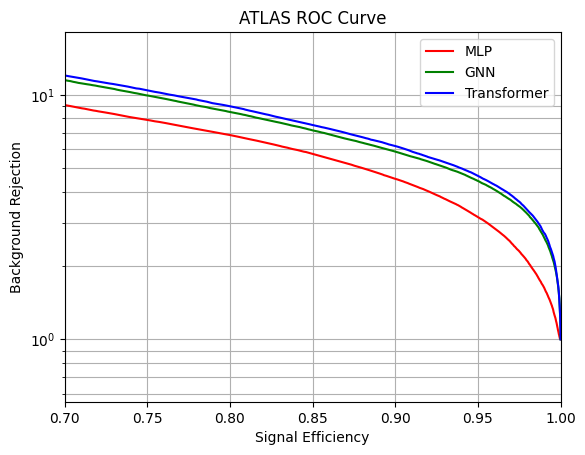

In [17]:
# Plot Tradiation ROC Curve
MLP_eff_sig, MLP_eff_bkg, MLP_thresh = roc(MLP_pred,MLP_true)
GNN_eff_sig, GNN_eff_bkg, GNN_thresh = roc(GNN_pred,GNN_true)
Trans_eff_sig, Trans_eff_bkg, Trans_thresh = roc(Trans_pred,Trans_true)

plt.title("ROC Curve")
plt.plot(MLP_eff_sig,MLP_eff_bkg,color='r',label="MLP")
plt.plot(GNN_eff_sig,GNN_eff_bkg,color='g',label="GNN")
plt.plot(Trans_eff_sig,Trans_eff_bkg,color='b',label="Transformer")
plt.plot([1,0],'--',color='k',label="Random Model")
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.legend()
plt.show()

# Plot ATLAS Style ROC Curve
MLP_eff_sig, MLP_eff_bkg, MLP_thresh = ATLAS_roc(MLP_pred,MLP_true)
GNN_eff_sig, GNN_eff_bkg, GNN_thresh = ATLAS_roc(GNN_pred,GNN_true)
Trans_eff_sig, Trans_eff_bkg, Trans_thresh = ATLAS_roc(Trans_pred,Trans_true)

plt.title("ATLAS ROC Curve")
plt.plot(MLP_eff_sig,MLP_eff_bkg,color='r',label="MLP")
plt.plot(GNN_eff_sig,GNN_eff_bkg,color='g',label="GNN")
plt.plot(Trans_eff_sig,Trans_eff_bkg,color='b',label="Transformer")
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Rejection")
plt.yscale('log')
plt.grid(True,which='both')
plt.xlim([0, 1])
plt.legend()
plt.show()

plt.title("ATLAS ROC Curve")
plt.plot(MLP_eff_sig,MLP_eff_bkg,color='r',label="MLP")
plt.plot(GNN_eff_sig,GNN_eff_bkg,color='g',label="GNN")
plt.plot(Trans_eff_sig,Trans_eff_bkg,color='b',label="Transformer")
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Rejection")
plt.yscale('log')
plt.grid(True,which='both')
plt.xlim([0, 0.2])
plt.legend()
plt.show()

plt.title("ATLAS ROC Curve")
plt.plot(MLP_eff_sig,MLP_eff_bkg,color='r',label="MLP")
plt.plot(GNN_eff_sig,GNN_eff_bkg,color='g',label="GNN")
plt.plot(Trans_eff_sig,Trans_eff_bkg,color='b',label="Transformer")
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Rejection")
plt.yscale('log')
plt.grid(True,which='both')
plt.xlim([0.7, 1])
plt.ylim([0, 18])
plt.legend()
plt.show()